In [ ]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = '/content/drive/MyDrive/nuclei/images/'
print(len(os.listdir(image_dir)))

5000


000000.png
000001.png
000002.png
000003.png
000004.png
000005.png
000006.png
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png

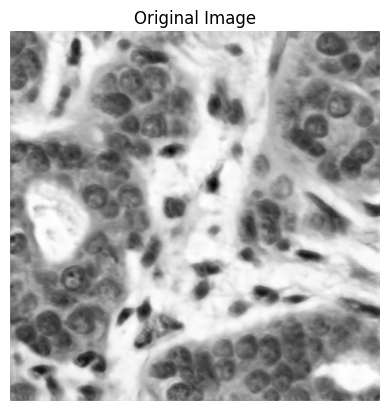

In [ ]:
imgs = []
for fn in sorted(os.listdir(image_dir)):
  print(fn)
  im = cv2.imread(image_dir + fn)
  blue, green, red = cv2.split(im)
  #im = cv2.resize(red,(128, 128))
  im = red
  imgs.append(im)

#plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
plt.imshow(imgs[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

In [ ]:
mask_dir = '/content/drive/MyDrive/nuclei/mask/'
print(len(os.listdir(image_dir)))

5000


Streaming output truncated to the last 5000 lines.
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png
000091.png
000092.png
000

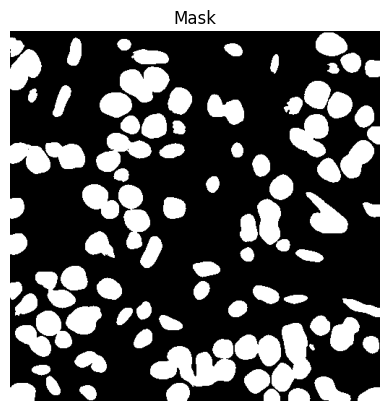

In [ ]:
masks = []
for fn in sorted(os.listdir(mask_dir)):
  print(fn)
  temp = cv2.imread(mask_dir + fn)
  grayscale_image = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
  # grayscale_image = cv2.resize(grayscale_image,(128, 128))
  grayscale_image[grayscale_image > 0] = 1
  masks.append(grayscale_image)

print(masks[0])
plt.imshow(masks[0], cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [ ]:
train_imgs, test_imgs = imgs[:4000], imgs[4000:]
train_masks, test_masks = masks[:4000], masks[4000:]

train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

train_masks = np.array(train_masks)
test_masks = np.array(test_masks)

train_imgs = train_imgs/255.0
test_imgs = test_imgs/255.0

print(train_imgs.shape)
print(test_imgs.shape)
print(train_masks.shape)
print(test_masks.shape)

(4000, 512, 512)
(1000, 512, 512)
(4000, 512, 512)
(1000, 512, 512)


In [ ]:
class UNET:
    def __init__(self, inp_shape=(512, 512, 1)):
        # parameters that were reused on every convolution
        C2D_params = {
            'kernel_size': (3, 3),
            'activation': 'relu',
            'kernel_initializer': 'he_normal',
            'padding': 'same'
        }

        trans_params = {
            'kernel_size': (2, 2),
            'strides': (2, 2),
            'padding': 'same'
        }

        # initialization
        inputs = tf.keras.layers.Input(inp_shape)

        # encoder
        c1 = Conv2D(16, **C2D_params)(inputs)
        c1 = Dropout(0.1)(c1)
        c1 = Conv2D(16, **C2D_params)(c1)
        p1 = MaxPooling2D((2, 2))(c1)

        c2 = Conv2D(32, **C2D_params)(p1)
        c2 = Dropout(0.1)(c2)
        c2 = Conv2D(32, **C2D_params)(c2)
        p2 = MaxPooling2D((2, 2))(c2)

        c3 = Conv2D(64, **C2D_params)(p2)
        c3 = Dropout(0.2)(c3)
        c3 = Conv2D(64, **C2D_params)(c3)
        p3 = MaxPooling2D((2, 2))(c3)

        c4 = Conv2D(128, **C2D_params)(p3)
        c4 = Dropout(0.2)(c4)
        c4 = Conv2D(128, **C2D_params)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        # valley
        c5 = Conv2D(256, **C2D_params)(p4)
        c5 = Dropout(0.3)(c5)
        c5 = Conv2D(256, **C2D_params)(c5)

        # decoder
        u6 = Conv2DTranspose(128, **trans_params)(c5)
        u6 = concat([u6, c4])
        c6 = Conv2D(128, **C2D_params)(u6)
        c6 = Dropout(0.2)(c6)
        c6 = Conv2D(128, **C2D_params)(c6)

        u7 = Conv2DTranspose(64, **trans_params)(c6)
        u7 = concat([u7, c3])
        c7 = Conv2D(64, **C2D_params)(u7)
        c7 = Dropout(0.2)(c7)
        c7 = Conv2D(64, **C2D_params)(c7)

        u8 = Conv2DTranspose(32, **trans_params)(c7)
        u8 = concat([u8, c2])
        c8 = Conv2D(32, **C2D_params)(u8)
        c8 = Dropout(0.1)(c8)
        c8 = Conv2D(32, **C2D_params)(c8)

        u9 = Conv2DTranspose(16, **trans_params)(c8)
        u9 = concat([u9, c1], axis=3)
        c9 = Conv2D(16, **C2D_params)(u9)
        c9 = Dropout(0.1)(c9)
        c9 = Conv2D(16, **C2D_params)(c9)

        # unet output
        out = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        # compile our unet
        unet = tf.keras.Model(inputs=[inputs], outputs=[out])
        unet.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=
             [
                'accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()
             ]
        )

        self.model = unet

In [ ]:
unet = UNET()
unet.model.load_weights('/content/drive/MyDrive/nuclei/epochs/nuclei-epoch-50.hdf5')
loss, accuracy, auc, precision, recall = unet.model.evaluate(test_imgs, test_masks, verbose=2)

32/32 - 83s - loss: 0.0390 - accuracy: 0.9840 - auc_4: 0.9981 - recall_4: 0.9556 - precision_4: 0.9559 - 83s/epoch - 3s/step


In [ ]:
print("Accuracy: {:5.2f}%".format(100 * accuracy))
print("AUC: {:5.2f}%".format(100 * auc))
print("Precision: {:5.2f}%".format(100 * precision))
print("Recall: {:5.2f}%".format(100 * recall))

Accuracy: 98.40%
AUC: 99.81%
Precision: 95.56%
Recall: 95.59%


In [ ]:
unet.model.history

In [ ]:
print(test_imgs.shape)
preds = unet.model.predict(test_imgs)

(1000, 512, 512)
32/32 [==============================] - 72s 2s/step


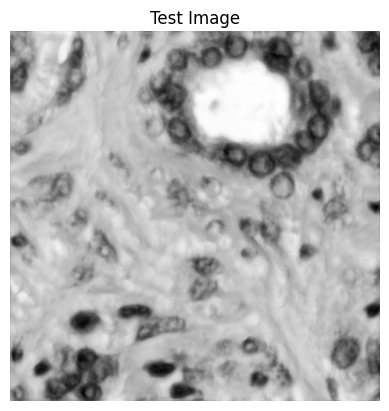

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

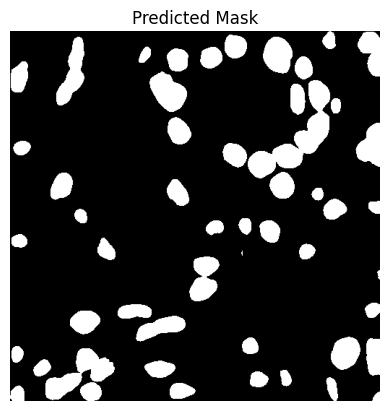

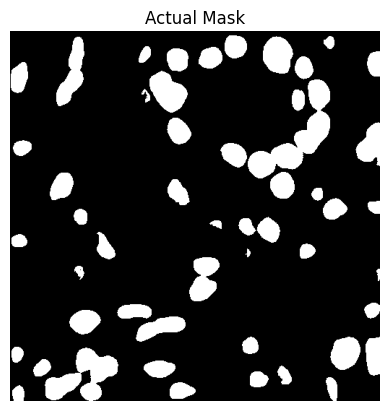

In [ ]:
img_to_test = 0

plt.imshow(test_imgs[img_to_test], cmap='gray')
plt.title('Test Image')
plt.axis('off')
plt.show()

test_preds = preds.copy()

# cv2.imwrite('/content/drive/MyDrive/nuclei/pred_4004.png', test_preds[img_to_test]*255.0)

new_preds = []
for i in range(len(test_preds)):
  temp = cv2.convertScaleAbs(test_preds[i])
  _, temp = cv2.threshold(temp, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  new_preds.append(temp)
  cv2.imwrite('/content/drive/MyDrive/nuclei/predicted_masks/pred_post_' + str(i) + '.png', new_preds[i]*255.0)


plt.imshow(new_preds[img_to_test], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

plt.imshow(test_masks[img_to_test], cmap='gray')
plt.title('Actual Mask')
plt.axis('off')
plt.show()